# 量的データ用（For quantitaive data）
[Methods]  
- Clustering methods : Kmeans, GMM, FSSEM, FSS-Kmeans    
- Allocation methods : random, proportional allocation, post stratification, optimal allocation

-------------
### ライブラリのインポート＆その他の設定（Importing Libraries & Other Settings）

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# シード設定
from lightning.pytorch import seed_everything

seed_everything(8)

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib

import itertools

plt.style.use("ggplot")

from collections import Counter

Seed set to 8


--------
### 実験設定

In [2]:
clusters = 2  # クラスタ数
n_features_to_select = 2  # 選択される最大の特徴量数

SAMPLE_SIZE = 1000  # 標本サイズ
data_size = 30000  # データサイズ(df2)
H = clusters  # 層の数
N_TRIALS = 100  # 試行回数（標本平均を求める回数）
N_EXPERIMENT = 1  # 分散を求める回数
m_VALUE = 2  # 各クラスタの最小標本数(最適標本配分)
RANDOM_STATE = 0  # 乱数シード
ALLOCATION_METHODS = [
    "ProportionalAllocation",
    "PostStratification",
    "OptimalAllocation",
]  # "RandomAllocation"はいれない
CLUSTERING_METHOD_LIST = ["kmeans"]  # ["gmm", "kmeans"]

SELECTING_FEATURES = (
    "all_features"  # "all_features" or "not_all_features" #特徴量をすべて選ぶかどうか
)

-----------
### データの前処理（Data Preprocessing）

##### 外れ値を除去する関数

In [3]:
# 外れ値の除去
def remove_outliers_zscore(
    data: pd.DataFrame, metric: str, threshold: float = 2
) -> pd.DataFrame:
    z_scores = np.abs(stats.zscore(data[metric]))
    data = data[(z_scores < threshold)]
    return data

##### メルカリデータ（df1：全部, df2：一部）

In [4]:
# df1(all the data)
df1 = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\aug_first_cpn_data_for_ab_test_sensibility_tsukuba.csv"
)
obj1 = "GMV"
features_list1 = [
    "hist_4_day_buy_num",
    "hist_4_day_gmv",
    "his_4_day_is_buy",
    "hist_30_day_buy_days",
    "hist_30_day_buy_num",
    "hist_30_day_gmv",
    "hist_30_day_buy_recency",
    "hist_30_day_pay_days",
    "hist_30_day_atpu",
    "hist_30_day_gpv",
    "hist_30_day_pay_recency",
    "hist_30_day_list_days",
    "hist_30_day_list_num",
    "hist_30_day_list_recency",
    "hist_30_day_like_count",
    "hist_30_day_like_count_not_deleted",
    "hist_30_day_like_recency",
]

# df2(subset of the data)
df2 = df1.iloc[:data_size]
obj2 = obj1
features_list2 = features_list1

##### 外れ値除去と標準化

In [5]:
df = df2  # choose from (df1, df2)
obj = obj2  # choose from (obj1, obj2)
features_list = features_list2  # choose from (features_list1, features_list2)

# 外れ値除去
df = remove_outliers_zscore(df, obj)

# 標準化
X = df[features_list]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
X_scaled = pd.DataFrame(scaled_features, columns=features_list)

# 目的変数
y = df[obj]

# 行を詰める
df = df.reset_index(drop=True)

-------------
### 提案手法でクラスタリング

##### Allocation_in_Wrapper Class
とりあえずproportional でやってみる  
・データによってはクラスタ数=3と指定した場合も2になることもある  
⇒ この場合はstopする

In [6]:
class Allocation_in_Wrapper(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        n_features_to_select: int,
        n_clusters: int,
        clustering_method: str = "kmeans",
        allocation_methods: list[str] = ["ProportionalAllocation"],
        sample_size: int = 10,
        n_trials: int = 100,
        m_value=2,
        M: Optional[NDArray] = None,
        random_state: int = 0,
        selecting_features: str = "all_features",
    ):
        self.n_features_to_select = n_features_to_select
        self.n_clusters = n_clusters
        self.clustering_method = clustering_method
        self.allocation_methods = allocation_methods
        self.sample_size = sample_size
        self.n_trials = n_trials
        self.m_value = m_value
        self.M = M
        self.H = n_clusters
        self.random_state = random_state
        self.selecting_features = selecting_features

    def fss(
        self, X: pd.DataFrame, y: pd.DataFrame
    ) -> "Allocation_in_Wrapper":  ###これ自体は多分あってる
        X, y = check_X_y(X, y)
        n_features = X.shape[1]  # 総特徴量数
        self.selected_features_dict = {}
        self.final_cluster_assignments_dict = {}
        self.features_score_dict = {}

        # ランダムの分散を計算
        self.random_allocation_std = self.cauculate_random_std(X, y)
        print(self.random_allocation_std)

        # 特徴量選択
        for allocation_method in self.allocation_methods:
            print("[", allocation_method, "]")

            features_score_dict = {}  # 確認用

            # 選ばれた特徴量と残っている特徴量の初期化
            current_features = []
            remaining_features = list(range(n_features))
            if self.selecting_features == "not_all_features":
                best_score = -np.inf

            while len(current_features) < self.n_features_to_select:
                if self.selecting_features == "all_features":
                    best_score = -np.inf
                best_feature = None  # 選ぶ特徴量の初期化

                for feature in remaining_features:
                    temp_features = tuple(
                        current_features + [feature]
                    )  # 特徴量をひとつ加え、score計算    ###########ここまでok
                    print("temp_features", temp_features)
                    score = self.crit(X[:, temp_features], y, allocation_method)
                    print("score", score)
                    if score > best_score:
                        print("特徴量更新")
                        best_score = score
                        best_feature = feature

                if best_feature is not None:
                    current_features.append(
                        best_feature
                    )  # best feature をcurrent features に追加
                    num_of_features = len(current_features)
                    self.y_hat_df_random = self.cauculate_random_std(X, y)
                    features_score = self.crit(
                        X[:, current_features], y, allocation_method
                    )   #ここが間違ってそう
                    print(
                        "num_of_features:",
                        num_of_features,
                        "current_features:",
                        current_features,
                        ", score:",
                        features_score,
                    )

                    features_score_dict[str(num_of_features)] = features_score  # 確認用

                    remaining_features.remove(
                        best_feature
                    )  # best feature をremaining features から取り除く
                    self.selected_features_ = current_features
                else:
                    break

                # 選ばれた特徴量サブセットでクラスタリング
                final_features = X[:, self.selected_features_]
                if self.clustering_method == "gmm":
                    final_model_ = GaussianMixture(
                        n_components=self.n_clusters,
                        random_state=self.random_state,
                        init_params="kmeans",
                    )
                elif self.clustering_method == "kmeans":
                    final_model_ = KMeans(
                        n_clusters=self.n_clusters, random_state=self.random_state
                    )
                else:
                    raise ValueError(
                        f"Unknown clustering method: {self.clustering_method}"
                    )

                final_model_.fit(final_features)
                self.final_cluster_assignments_dict[allocation_method] = (
                    final_model_.predict(final_features)
                )
                self.features_score_dict[allocation_method] = (
                    features_score_dict  # 確認用
                )

                self.selected_features_dict[allocation_method] = self.selected_features_

        return self

    def crit(
        self, X: pd.DataFrame, y: pd.DataFrame, allocation_method: str
    ) -> float:  ##これ自体は大丈夫
        # クラスタリング手法がGMMの場合
        if self.clustering_method == "gmm":
            em = GaussianMixture(
                n_components=self.n_clusters,
                random_state=self.random_state,
                init_params="kmeans",
            )
            em.fit(X)
            self.N_cluster_label = em.predict(X)
            self.N_cluster_size = np.bincount(self.N_cluster_label, minlength=clusters)

        # クラスタリング手法がKMEANSの場合
        if self.clustering_method == "kmeans":
            kmeans = KMeans(
                n_clusters=self.n_clusters,
                random_state=self.random_state,
            )
            kmeans.fit(X)
            self.N_cluster_label = kmeans.predict(X)
            self.N_cluster_size = np.bincount(self.N_cluster_label, minlength=clusters)

        if (
            0 in self.N_cluster_size
        ):  # 母集団のクラスタ数が十分でない場合score=0 にする(あとでかえる)
            score = 0
        else:  ###################
            error_variance_reduction_rate = self.cauculate_reduction_rate(
                X, y, allocation_method
            )
            score = error_variance_reduction_rate

        return score

    def cauculate_reduction_rate(
        self, X: pd.DataFrame, y: pd.DataFrame, allocation_method: str
    ) -> float:  ######これ自体は大丈夫
        # 各戦略の標本数に基づいて目的変数の平均を推定
        y_hats = []
        for random_state in range(N_TRIALS):
            if allocation_method == "PostStratification":
                y_hat = self.estimate_y_mean_post(X, y)
            else:
                y_hat = self.estimate_y_mean_other(X, y, allocation_method)
            y_hats.append(
                {
                    "policy": allocation_method,
                    "y_hat": y_hat,
                    "random_state": random_state,
                }
            )

        y_hat_df = pd.DataFrame(y_hats)
        y_hat_df["error"] = (
            y_hat_df["y_hat"] - y.mean()
        )  # 真の平均からの誤差をerrorカラムに追加

        non_random_allocation_std = y_hat_df["error"].var()
        # 削減率
        reduction_rate = (
            1 - non_random_allocation_std / self.random_allocation_std
        ) * 100

        return reduction_rate

    def cauculate_random_std(self, X, y):  # 多分あってる
        y_hats = []
        for random_state in range(self.n_trials):
            sample = np.random.choice(y, self.sample_size, replace=False)
            y_hat_random = sample.mean()
            y_hats.append(
                {
                    "policy": "RandomAllocation",
                    "y_hat": y_hat_random,
                    "random_state": random_state,
                }
            )

        y_hat_df = pd.DataFrame(y_hats)
        y_hat_df["error"] = y_hat_df["y_hat"] - y.mean()
        random_allocation_std = y_hat_df["error"].var()
        return random_allocation_std

    def estimate_y_mean_post(self, X, y) -> float:
        n_cluster_size = np.array([self.sample_size])

        weights = self.N_cluster_size / self.N_cluster_size.sum()
        y_hat = 0
        indices = np.arange(self.N_cluster_size.sum())
        y_array = np.array(y.tolist())
        n_indices = np.random.choice(indices, n_cluster_size[0], replace=False)
        n_label = np.array([self.N_cluster_label[i] for i in n_indices])
        n_new_labels = np.unique(n_label)
        for h in n_new_labels:
            index = np.where(n_label == h)[0]
            sample = y_array[n_indices[index]]
            y_sample_mean = sample.mean()  # サンプリングした標本の平均
            y_hat += y_sample_mean * weights[h]
        return y_hat

    def estimate_y_mean_other(self, X, y, allocation_method) -> float:  # 多分あっている
        if allocation_method == "ProportionalAllocation":
            n_cluster_size = self.ProportionalAllocation(X, y)
        if allocation_method == "OptimalAllocation":
            n_cluster_size = self.OptimalAllocation(X, y)

        weights = self.N_cluster_size / self.N_cluster_size.sum()
        y_hat = 0
        for h in range(n_cluster_size.shape[0]):
            if n_cluster_size[h] != 0:
                y_cluster = y[self.N_cluster_label == h]

                sample: NDArray = np.random.choice(
                    y_cluster, n_cluster_size[h], replace=False
                )
                y_sample_mean = sample.mean()  # サンプリングした標本の平均
                y_hat += y_sample_mean * weights[h]
        return y_hat

    def get_feature_index_out(self) -> dict[NDArray]:
        return self.selected_features_dict  # 選択された特徴量のインデックス

    def get_final_cluster_assignments(self) -> dict[NDArray]:
        return self.final_cluster_assignments_dict  # 最終的なクラスタリング結果

    def get_features_score(self) -> dict[dict]:
        return self.features_score_dict

    def ProportionalAllocation(self, X, y) -> NDArray:
        n_cluster_size: NDArray = np.round(
            self.N_cluster_size / self.N_cluster_size.sum() * self.sample_size
        ).astype(int)

        if n_cluster_size.sum() > self.sample_size:
            # nの合計がn_samplesより大きい場合は一番標本数が多いクラスタから削る
            n_cluster_size[np.argmax(n_cluster_size)] -= (
                n_cluster_size.sum() - self.sample_size
            )
        if n_cluster_size.sum() < self.sample_size:
            # nの合計がn_samplesより小さい場合は一番標本数が多いクラスタにたす
            n_cluster_size[np.argmax(n_cluster_size)] += (
                -n_cluster_size.sum() + self.sample_size
            )

        return n_cluster_size

    def OptimalAllocation(self, X, y) -> NDArray:
        self.m = np.full(H, self.m_value)
        # S:クラスタ毎の目的変数のvarianceを要素とする配列 (H, )
        S = np.array([np.var(y[self.N_cluster_label == h]) for h in range(self.H)])
        d = (self.N_cluster_size**2) * S  # (H, )

        n_cluster_size = self.m.copy()
        M = self.M.copy() if self.M is not None else self.N_cluster_size.copy()
        I = np.arange(self.H)  # noqa #クラスタのインデックス
        while (n_cluster_size.sum() != self.sample_size) and len(I) != 0:
            delta = np.zeros(self.H)
            delta[I] = (d / (n_cluster_size + 1) - d / n_cluster_size)[I]
            h_star = np.argmin(delta[I])
            h_star = I[h_star]

            if n_cluster_size[h_star] + 1 <= M[h_star]:
                n_cluster_size[h_star] = n_cluster_size[h_star] + 1
            else:
                # Iの要素h_starを削除
                I_ = I.tolist()
                I_ = [i for i in I_ if i != h_star]
                I = np.array(I_)  # noqa

        # 制約チェック
        assert (
            n_cluster_size.sum() <= self.sample_size
        ), f"Total sample size is over than {self.sample_size}"
        assert np.all(
            n_cluster_size >= self.m
        ), "Minimum sample size constraint is not satisfied"
        if self.M is not None:
            assert np.all(
                n_cluster_size <= self.M
            ), "Maximum sample size constraint is not satisfied"

        return n_cluster_size

29790.226367296567
[ ProportionalAllocation ]
temp_features (0,)


c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


score 30.920216818901746
特徴量更新
temp_features (1,)
score 23.531527939484953
temp_features (2,)
score 31.942638731650963
特徴量更新
temp_features (3,)
score 41.40339468063
特徴量更新
temp_features (4,)
score 30.595165638711062
temp_features (5,)
score 46.258216552436984
特徴量更新
temp_features (6,)
score 21.399305219764564
temp_features (7,)
score 28.849785288474784
temp_features (8,)
score 27.948437302486262
temp_features (9,)
score 36.87678181395978
temp_features (10,)
score 40.760088986208345
temp_features (11,)
score 28.764443587963672
temp_features (12,)
score 14.72902764059285
temp_features (13,)
score 18.356005048423963
temp_features (14,)
score 27.731539668152816
temp_features (15,)
score 33.51162457956036
temp_features (16,)
score 12.299962334593095
num_of_features: 1 current_features: [5] , score: 35.511414879956114
temp_features (5, 0)
score 43.81651752666779
特徴量更新
temp_features (5, 1)
score 27.782409509812467
temp_features (5, 2)
score 23.272930710116345
temp_features (5, 3)
score 32.61851

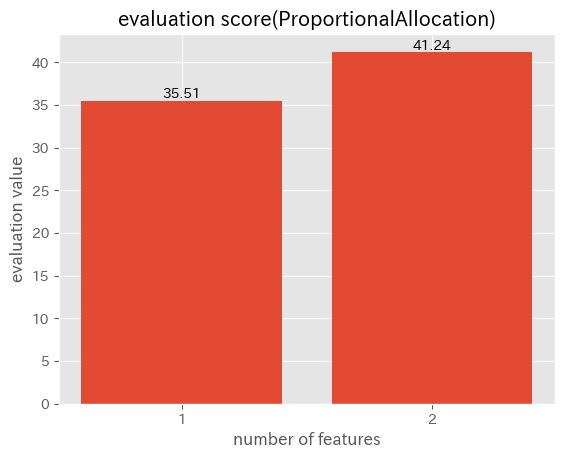

In [7]:
ins = Allocation_in_Wrapper(
    n_features_to_select=n_features_to_select,
    n_clusters=clusters,
    clustering_method="kmeans",
    allocation_methods=["ProportionalAllocation"],
    sample_size=1000,
    n_trials=100,
    m_value=2,
    random_state=0,
    selecting_features="all_features",
)

ins.fss(X_scaled, y)
selected_features_index = ins.get_feature_index_out()
cluster_label = ins.get_final_cluster_assignments()
cluster_size = np.unique(cluster_label, return_counts=True)[1]
features_score_dict = ins.get_features_score()
print(features_score_dict)

for allocation, dict in features_score_dict.items():
    plt.bar(dict.keys(), dict.values())
    for key, value in dict.items():
        rounded_value = round(value, 2)
        plt.text(key, value + 0.3, str(rounded_value), ha="center")
    plt.title(f"evaluation score({allocation})")
    plt.xlabel("number of features")
    plt.ylabel("evaluation value")
    plt.show()